In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage import feature
from skimage.transform import probabilistic_hough_line

In [2]:
def Load_and_Prepare(filename):
#filename: Image file name
    image = io.imread(filename)
    image = rgb2gray(image)
    image = gaussian(image)
    return image

In [3]:
def Edge_Detect(image,S_val,LT_val,HT_val):
#image: Grayscale input image
#S_val: Standard deviation of the Gaussian filter
#LT_val: Lower bound for hysteresis thresholding
#HT_val: Upper bound for hysteresis thresholding
    return feature.canny(image, sigma = S_val, low_threshold = LT_val, high_threshold= HT_val)  

In [4]:
def Orientation_Map_Compute(cellsize,n,edges):
#cellsize: cell size in pixel
#n: number of bins for orientation binning
#edges: numpy array of the image after edge detection (type= boolean)
    
    work_size = cellsize #
    v_size = edges.shape[0]
    h_size = edges.shape[1]

    label_list = np.zeros([int(v_size/work_size),int(h_size/work_size)])
    strength_list= np.zeros([int(v_size/work_size),int(h_size/work_size)])
    
    for (i,j), x in np.ndenumerate(label_list):
        v = i*work_size
        h = j*work_size
        
        detecting = edges[v:v+work_size,h:h+work_size]
        lines = probabilistic_hough_line(detecting,line_length=5, line_gap=2,seed=0)
        rads = []
        
        votes = np.zeros(n)
        binsize = (np.pi/n)
        
        for line in lines:
            p0, p1 = line
            deltay = p1[1] - p0[1]
            deltax = p1[0] - p0[0]
            angle_rad = np.arctan2(deltay,deltax)
            
            if angle_rad <0:
                angle_rad = angle_rad+np.pi
            rads = np.append(rads,angle_rad)

            down = int(angle_rad/binsize)
            up = down + 1
            vote_up =  (angle_rad - (down*binsize)) / binsize
            vote_down = ((up*binsize) - angle_rad)/ binsize
            if up > n-1:
                up = up - n
            if down > n-1:
                down = down - n
            votes[down]= votes[down] + vote_down
            votes[up] = votes[up] + vote_up

        strength = (np.amax(votes))/(np.sum(votes))
        strength_list[i,j] = strength 
        if strength >= 0.0:
            label = (np.argmax(votes))
            label_list[i,j] = label
        else:
            label_list[i,j] = np.nan
    return (label_list)
#return an array of orientation labels
#orientation labelled as integers (0, 1, 2, 3, etc.) for bin centres (0°, 20°, 30°, ...; or 0°, 0 + binsize, 0 + 2*binsize, ...)

# Demonstration - Orientation Mapping (OM)

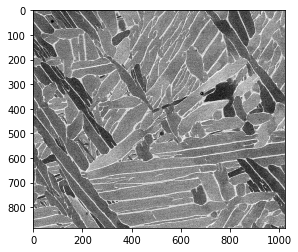

In [5]:
image = Load_and_Prepare('Demo_OM.tif')
plt.imshow(image,'gray')

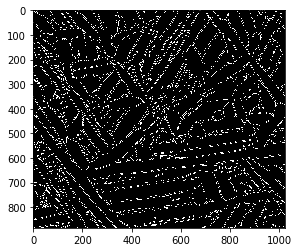

In [6]:
S_val = 0
LT_val = 0.3
HT_val = 0.7
#adjut above value for edge detection parameters
edges = Edge_Detect(image,S_val,LT_val,HT_val)
plt.imshow(edges,'gray')

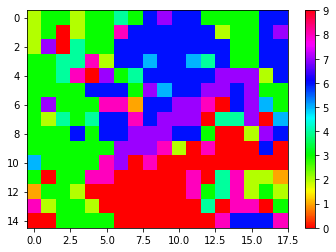

In [7]:
cellsize = 56
n = 9
OM_data = Orientation_Map_Compute(cellsize,n,edges)
plt.imshow(OM_data,'hsv', vmin=0,vmax=n)
plt.colorbar()

# Deomonstration - Orientation Scanning

In [12]:
def Scan_Area(cellsize,image):
    return image[int(image.shape[0]/2)-(7*cellsize):int(image.shape[0]/2)+(8*cellsize),:]

def Scan_Compute(image_w,n,S_val,LT_val,HT_val):
    runs = int(image_w.shape[1]/cellsize)-5
    start = int(0)
    count=np.zeros((n+1,runs))
    for run in range(runs):
        working = image_w[:,start:start+cellsize*5]
        edges = Edge_Detect(working,S_val,LT_val,HT_val)
        data = Orientation_Map_Compute(cellsize,n,edges)
        label = np.array(range(n+1))
        for i,a in np.ndenumerate(label):
            c = np.count_nonzero(data == a)
            count[i,run] = c
        count[-1,run] = np.isnan(data).sum()
        start = start + int(cellsize*1)
    return count

def Plot_OCM(data_OCM)

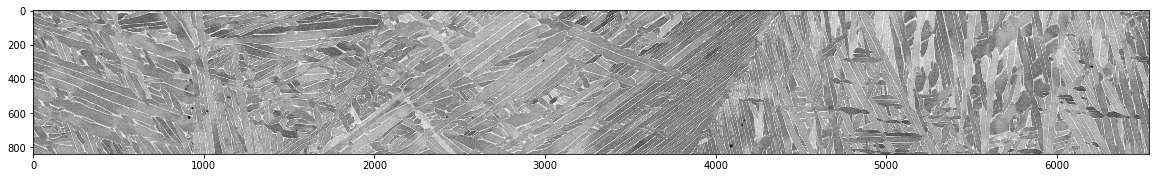

In [40]:
image = Load_and_Prepare('Demo_OCM.png')
cellsize = 56
image_w = Scan_Area(cellsize,image)
plt.figure(figsize=(20,5))
plt.imshow(image_w,'gray')


In [13]:
n=9
S_val = 0
LT_val = 0.3
HT_val = 0.7
data_OCM = Scan_Compute(image_w,n,S_val,LT_val,HT_val)

C:\Users\wilbu\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [41]:
Y = ['0°', '20°', '40°','60°','80°','100°','120°','140°','160°','N/A']
import matplotlib
color_map = np.zeros((n+1,4))
cmap = matplotlib.cm.get_cmap('hsv')
for N in range(n):
    rgba = (np.array(cmap(N/9)))
    color_map[N]=rgba
color_map[n] = [0,0,0,1]

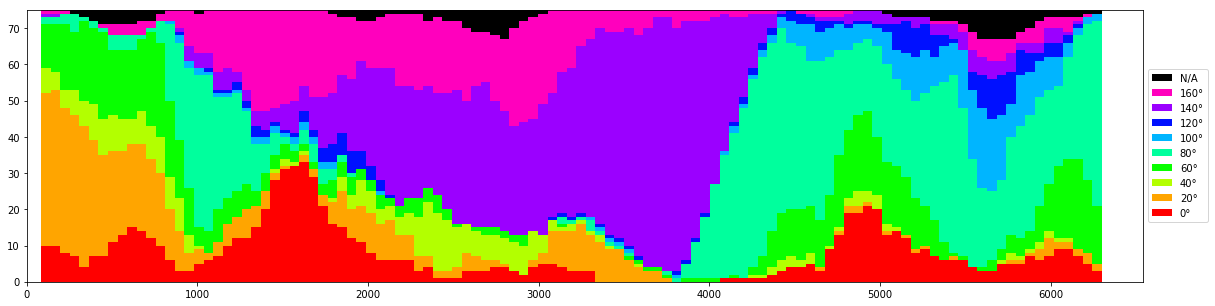

In [42]:
fig, ax = plt.subplots(figsize=(20,5))

X = (np.arange(data_OCM.shape[1])+2)*cellsize

for i in range(data_OCM.shape[0]):
    vars()['p'+str(i)] = ax.bar(X, data_OCM[i],bottom = np.sum(data_OCM[:i], axis = 0),width=1.0*cellsize,color=color_map[i])
P = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9] #still need to manually add to p'n'
ax.set_xlim([0,image_w.shape[1]])
ax.legend(P[::-1],Y[::-1] , loc='center left', bbox_to_anchor=(1, 0.5))

['p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9']
